In [1]:
# Compile the graph into class
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from colormap import Color
import datetime
import time
#import mplleaflet
import ipywidgets as widgets
import salem
import motionless
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
#from mpl_toolkits.mplot3d import Axes3D
#from mpld3 import plugins
#import mpld3


class AllPurpose:    
    column_name = {'names': 'names',
                   'dates':'dates',
                   'latitude':'latitude',
                   'longitude':'longitude',
                   'categorical': 'categorical',
                   'quant1': 'quant1',
                   'quant2': 'quant2',
                   'quant3': 'quant3'                  
                  }
        
    def __init__(self,data,column_name={},datestr = '%d/%m/%y'):
        self.data = data
        for key in self.column_name.keys():
            if key in column_name.keys():
                self.column_name[key] = column_name[key]
        self.initColumns()
        self.datestr = datestr
                
    def initColumns(self):
        self.cnames = self.column_name['names']
        self.cdates = self.column_name['dates']
        self.clatitude = self.column_name['latitude']
        self.clongitude = self.column_name['longitude']
        self.ccategorical = self.column_name['categorical']
        self.cquant1 = self.column_name['quant1']
        self.cquant2 = self.column_name['quant2']
        self.cquant3 = self.column_name['quant3']
        
        
        group_cat = sample.groupby('categorical')['categorical'].count()
        group_cat
        self.cat_dictionary = group_cat.index.values
        
        temp = self.data[self.cnames].unique().tolist()
        self.names_list = ['All Names']
        [self.names_list.append(x) for x in temp]
        

        
    # Function to generate General statistics plot
    def plotGeneralStat(self, color='Paired', filename='generalstat.png'):
        dataFig = plt.figure(figsize=(15,15))
        # make super title
        dataFig.suptitle('General Statistics for Dataset')
        # Make Pie Chart
        ax1 = dataFig.add_subplot(2,2,1)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)    
        freqCat = sample.groupby(self.ccategorical)[self.ccategorical].count()

        
        pie_wedge_collection = ax1.pie(freqCat,labels=freqCat.index)

        # define color map for all categories
        cm = plt.get_cmap(color)
        norm = mpl.colors.Normalize(vmin=0,vmax=len(self.ccategorical))

        i = 0
        colorArr = []
        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor('white')
            pie_wedge.set_facecolor(cm(norm(i)))
            colorArr.append(cm(norm(i)))
            i+=1
                    
        ax1.set_title('Category Frequency')
        quant1sum = sample.groupby(self.ccategorical)[self.cquant1].sum()/sample[self.cquant1].sum()
        quant2sum = sample.groupby(self.ccategorical)[self.cquant2].sum()/sample[self.cquant2].sum()
        quant3sum = sample.groupby(self.ccategorical)[self.cquant3].sum()/sample[self.cquant3].sum()

        ax2 = dataFig.add_subplot(2,2,2)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)    
        ax2.bar(range(1,len(quant1sum)+1),quant1sum.values,color=colorArr)
        ax2.set_title('{} Sum Over all Category'.format(self.cquant1))
        ax2.set_xlabel('Category')
        ax2.set_ylabel('Average Quantity')
        xticks = plt.xticks(range(1,len(quant1sum)+1),quant1sum.index,rotation=45)

        ax3 = dataFig.add_subplot(2,2,3)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)        
        ax3.bar(range(1,len(quant2sum)+1),quant2sum.values,color=colorArr)
        ax3.set_title('{} Sum Over all Category'.format(self.cquant2))
        ax3.set_xlabel('Category')
        ax3.set_ylabel('Average Quantity')
        xticks = plt.xticks(range(1,len(quant2sum)+1),quant2sum.index,rotation=45)


        ax4 = dataFig.add_subplot(2,2,4)    
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
        ax4.bar(range(1,len(quant3sum)+1),quant3sum.values,color=colorArr)
        ax4.set_title('{} Sum Over all Category'.format(self.cquant3))
        ax4.set_xlabel('Category')
        ax4.set_ylabel('Average Quantity')
        xticks = plt.xticks(range(1,len(quant3sum)+1),quant3sum.index,rotation=45)
        
        # save to file
        plt.savefig(filename)
        
        #dataFig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        
    def quantityBin(self,quant,binNumber=12,name='All Names'):
        sample = self.data
        # filter name
        if name!= 'All Names':
            sample = sample[sample[self.cnames]==name]        
        
        # preprocessed dates data for bining
        min_date = sample.dates.min()
        #print(min_date)
        max_date = sample.dates.max()
        #print(max_date)
        #print(max_date - min_date)
        binNum=binNumber+1
        
        bin_range = np.linspace(min_date,max_date,binNum)
        
        #print(bin_range)
        if len(bin_range) == 0:
            bin_range = sample.dates.sort().unique().tolist()
            

        bin_quant_arr = []
        x_labels = []    

        # calculate the quantity variables for each bins
        for i in range(len(bin_range)-1):
            #print(bin_range[i])
            bin_sample = sample[(sample[self.cdates]>=bin_range[i])&(sample[self.cdates]<=bin_range[i+1])]
            #print(len(bin_sample))
            bin_sums = bin_sample.groupby(self.ccategorical)[quant].sum()
            bin_mean = bin_sample.groupby(self.ccategorical)[quant].mean()
            bin_max = bin_sample.groupby(self.ccategorical)[quant].min()
            bin_min = bin_sample.groupby(self.ccategorical)[quant].max()
            bin_sd = bin_sample.groupby(self.ccategorical)[quant].std()
            zipped = pd.concat([bin_sums,bin_mean,bin_max,bin_min,bin_sd],join='inner',axis=1)
            bin_quant_arr.append(zipped)
            # add labels
            x_labels.append(datetime.datetime.fromtimestamp(bin_range[i]).strftime(self.datestr))

        x_labels.append(datetime.datetime.fromtimestamp(bin_range[i+1]).strftime(self.datestr))    

        #print(bin_quant_arr)

        categories = sample.categorical.unique()
        # prepare the array
        bin_cat_arr = {}
        for cat in categories:
            #bin_cat_arr[cat] = pd.DataFrame()
            bin_cat_arr[cat] = []

        for bin_quant in bin_quant_arr:
            for cat in categories:
                if cat in bin_quant.index and cat in bin_cat_arr:          
                    bin_cat_arr[cat].append(bin_quant.loc[cat]) 
                    #bin_cat_arr[cat] = pd.concat([bin_cat_arr[cat],bin_quant.loc[cat]],join='inner',axis=1)
                else:
                    bin_cat_arr[cat].append(np.zeros(5))
                    #bin_cat_arr[cat] = pd.concat([bin_cat_arr[cat],np.zeros(5)],join='inner',axis=1)
        return (bin_cat_arr,x_labels)            

    def show_quantity(self,categories,quant,shows,binNumber,name='All Names',color='viridis'):
        sample_fig = plt.figure(figsize=(15,15));
        sample_ax = sample_fig.add_subplot(1,1,1)
        (qBin,x_labels) = self.quantityBin(quant,binNumber,name)
        qBin = pd.DataFrame(qBin)
        #print()
        #ax.scatter(obs_stops['stop_lon'], obs_stops['stop_lat'],c=obs_stops.frequency,cmap=plt.get_cmap('viridis'),vmin=min_freq,vmax=max_freq,s=100,alpha=0.5,edgecolors='none')
        #color='viridis'
        # define color map for all categories
        cm = plt.get_cmap(color)
        colorArr = {}
        norm = mpl.colors.Normalize(vmin=0,vmax=len(categories))
        for i in range(len(categories)):
            color = cm(norm(i))
            colorArr[categories[i]] = color

        patch_array = []

        x_position = np.array(range(len(x_labels)-1)) + 0.5

        for cat in categories:
            if cat in qBin:
                bin_cat_arr = qBin[cat]
                plot_arr = {}
                # initialize plot_arr
                #print(bin_cat_arr)
                for i in range(bin_cat_arr[0].shape[0]):
                    plot_arr[i] = []
                for bin_cat in bin_cat_arr:
                    #print(bin_cat)
                    for i in range(bin_cat.index.shape[0]):
                        plot_arr[i].append(bin_cat.values[i])

                if 'Mean' in shows:
                    #sample_ax.plot(range(1,len(plot_arr[1])+1),plot_arr[1],'-',c=colorArr[cat])
                    sample_ax.plot(x_position.tolist(),plot_arr[1],'-',marker='o',c=colorArr[cat])
                    #scatter = sample_ax.scatter(x_position.tolist(),plot_arr[1],'.',alpha=0)
                    #tooltip = plugins.PointHTMLTooltip(scatter, plot_arr[1],voffset=10,hoffset=10)
                    #plugins.connect(sample_fig, tooltip)

                if '1-SD' in shows:
                    #sample_ax.plot(range(1,len(plot_arr[1])+1),np.array(plot_arr[1])-np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')
                    #sample_ax.plot(range(1,len(plot_arr[1])+1),np.array(plot_arr[1])+np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')
                    sample_ax.plot(x_position.tolist(),np.array(plot_arr[1])-np.array(plot_arr[4]),marker='o',c=colorArr[cat],linestyle='--')
                    sample_ax.plot(x_position.tolist(),np.array(plot_arr[1])+np.array(plot_arr[4]),marker='o',c=colorArr[cat],linestyle='--')

                if 'Min' in shows:
                    #sample_ax.plot(range(1,len(plot_arr[2])+1),plot_arr[2],'-.',c=colorArr[cat])
                    sample_ax.plot(x_position.tolist(),plot_arr[2],'-.',marker='o',c=colorArr[cat])
                if 'Max' in shows:
                    #sample_ax.plot(range(1,len(plot_arr[3])+1),plot_arr[3],'-.',c=colorArr[cat])
                    sample_ax.plot(x_position.tolist(),plot_arr[3],'-.',marker='o',c=colorArr[cat])
                if 'Sum' in shows:
                    #sample_ax.plot(range(1,len(plot_arr[3])+1),plot_arr[3],'-.',c=colorArr[cat])
                    sample_ax.plot(x_position.tolist(),plot_arr[0],'-',marker='o',c=colorArr[cat])

                    
                sample_ax.grid(color='black', linestyle='-.', linewidth=0.5)

                patch_array.append(mpl.patches.Patch(color=colorArr[cat],label=cat))

        # add lines legend
        patch_array.append(mpl.lines.Line2D([],[],linestyle='-',label='Mean/Sum',color='black'))
        patch_array.append(mpl.lines.Line2D([],[],linestyle='--',label='1-SD',color='black')) 
        patch_array.append(mpl.lines.Line2D([],[],linestyle='-.',label='Min/Max',color='black')) 
                
        xticks = plt.xticks(range(len(x_labels)),x_labels,rotation=45)

        sample_ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5))    

        sample_ax.set_xlabel('Time')
        sample_ax.set_ylabel('Quantity')
        sample_ax.set_title('Quantity Statistics Overtime')
        #mpld3.enable_notebook()
        
    def plotDetailStat(self):
        selectCategory = widgets.SelectMultiple(
            options = self.cat_dictionary.tolist(),
            value=[self.cat_dictionary[0]],
            description='Category'
        )

        dropdownQuantity = widgets.Dropdown(
            options = [self.cquant1,self.cquant2,self.cquant3],
            value=self.cquant1,
            description='Quantity Column'
        )

        selectCustomViz = widgets.SelectMultiple(
            options = ['Mean','Min','Max','1-SD','Sum'],
            value=['Mean','1-SD'],
            description='Show'
        )

        
        # print color_map
        allcmap = plt.colormaps()
        
        cmapArr = []
        for cmap in allcmap:
            if '_r' not in cmap:
                cmapArr.append(cmap)
        
        dropdownNames = widgets.Dropdown(
            options = self.names_list,
            value='All Names',
            description='Names'
        )     

        
        dropdownCmap = widgets.Dropdown(
            options = cmapArr,
            value='viridis',
            description='Color'
        )     
        
        sliderBin = widgets.IntSlider(
            value=12,
            min=1,
            max=80,
            step=1,
            description='Date Binning:',
            orientation='horizontal',
            readout=True,
            readout_format='i',
            slider_color='white'
        )

        widgets.interact(self.show_quantity,name=dropdownNames,categories=selectCategory,quant=dropdownQuantity,shows=selectCustomViz,binNumber=sliderBin,color=dropdownCmap)
        
        
    def spatial_bin_plot(self,category,quantity,bin_step=20,color='viridis'):
        # scale Dimension
        scaleDim = 5

        # Binning base on spatial
        data = self.data
        # filter the data by category
        data = data[data[self.ccategorical].isin(category)]
        # This maximum constant is what we can get from
        # the google map static image
        # greater or lower than these can produce error
        maxconst = (-86.82743293, 86.92841107, -176.1111116, 176.4292565)
        minlat = data[self.clatitude].min() if data[self.clatitude].min() > maxconst[0] else maxconst[0];
        maxlat = data[self.clatitude].max() if data[self.clatitude].max() < maxconst[1] else maxconst[1];
        minlong = data[self.clongitude].min() if data[self.clongitude].min() > maxconst[2] else maxconst[2];
        maxlong = data[self.clongitude].max() if data[self.clongitude].max() < maxconst[3] else maxconst[3];
        #print(minlat,maxlat,minlong,maxlong)
        g = GoogleVisibleMap(x=[minlong, maxlong], y=[minlat, maxlat],
                         maptype='terrain')  # satellitetry out also: 'terrain'    

        # the google static image is a standard rgb image
        ggl_img = g.get_vardata()
        #ax.imshow(ggl_img)
        # make a map of the same size as the image (no country borders)
        sm = Map(g.grid, factor=1, countries=False)
        sm.set_rgb(ggl_img)  # add the background rgb image    

        #print(minlat,maxlat,minlong,maxlong)
        # make range for Latitude
        # set step
        xstep = bin_step
        ystep = bin_step
        latBin = np.linspace(data[self.clatitude].min(),data[self.clatitude].max(),xstep);
        longBin = np.linspace(data[self.clongitude].min(),data[self.clongitude].max(),ystep)
        #logger.debug(latBin)
        #print(longBin)

        quantBinArr = []
        quantmeanArr = []
        quantsumArr = []

        latStepLen = latBin[1] - latBin[0]
        longStepLen = longBin[1] - longBin[0]

        #treesWithoutVacant = trees.filter_ne('Tree Species','vacant site large')
        for x in range(latBin.size):    
            if(x < latBin.size-1):
                latSelMin = latBin[x] if latBin[x] < latBin[x+1] else latBin[x+1]
                latSelMax = latBin[x] if latBin[x] > latBin[x+1] else latBin[x+1]

                #latData = data[(data['latitude']>latBin[x])&(data['latitude']<=latBin[x+1])]
                latData = data[(data[self.clatitude]>latSelMin)&(data[self.clatitude]<=latSelMax)]
                latmean = latSelMin + (latStepLen/2)
                for y in range(longBin.size):
                    if(y < longBin.size-1):
                        lonSelMin = longBin[y] if longBin[y] < longBin[y+1] else longBin[y+1]
                        lonSelMax = longBin[y] if longBin[y] > longBin[y+1] else longBin[y+1]                    

                        #print(lonSelMin,lonSelMax)
                        #print((latData['longitude']>lonSelMin)&(latData['longitude']<=lonSelMax))

                        #areaData = latData[(latData['longitude']>longBin[y])&latData['longitude']<longBin[y+1]]
                        areaData = latData[(latData[self.clongitude]>lonSelMin)&(latData[self.clongitude]<=lonSelMax)]
                        #print(areaData.shape)
                        # group the areaData by category to get the mean and sum category
                        meanCat = areaData.groupby(self.ccategorical)[quantity].mean().sort_values(ascending=False)
                        sumCat = areaData.groupby(self.ccategorical)[quantity].sum().sort_values(ascending=False)

                        """
                        # get mean for the quantity area bin
                        quantmean = areaData[quantity].mean()
                        quantsum = areaData[quantity].sum()
                        """
                        if areaData.shape[0] > 0:
                            longmean = lonSelMin + (longStepLen/2)
                            quantmeanArr.append(meanCat.max())
                            quantsumArr.append(sumCat.max())
                            #print(meanCat)
                            #print(sumCat)
                            quantBinArr.append({'lat': latmean, 'long': longmean, 'mean': meanCat, 'sum': sumCat})
                            """
                            quantmeanArr.append(quantmean)
                            quantsumArr.append(quantsum)
                            longmean = (longBin[y]+longBin[y+1])/2
                            quantBinArr.append({'lat': latmean, 'long': longmean, 'quantmean': quantmean, 'quantsum': quantsum})
                            """

        dataFig = plt.figure(figsize=(15,15))
        loc_ax = dataFig.add_subplot(1,1,1)
        sm.visualize(ax=loc_ax)  # plot it

    #    loc_ax.set_title('Distribution of Most Common Trees accross Spatial Binning: {}x{} square'.format(xstep,ystep))
        loc_ax.set_xlabel('Longitude')
        loc_ax.set_ylabel('Latitude')

        minMean = np.array(quantmeanArr).min()
        maxMean = np.array(quantmeanArr).max()
        # calculate the scale
        # we scale it using 8 level
        scale = (maxMean - minMean) / scaleDim

        #define color representation for each category
        cm = plt.get_cmap(color)
        colorArr = {}
        norm = mpl.colors.Normalize(vmin=0,vmax=len(category))

        patch_array = []
        for i in range(len(category)):
            color = cm(norm(i))
            colorArr[category[i]] = color
            patch_array.append(mpl.patches.Patch(color=color,label=category[i]))

        for quantBin in quantBinArr:
            x, y = sm.grid.transform(quantBin['long'],quantBin['lat'])        
            scatter = loc_ax.scatter(x,y,s=(quantBin['mean'].values[0]/scale)*(longStepLen/2)*scaleDim,c=colorArr[quantBin['mean'].index[0]],alpha=.75,edgecolors='none')        
            #tooltip = plugins.PointHTMLTooltip(scatter, ['test'])
            #plugins.connect(dataFig, tooltip)

            
        scale_array = []   
        scale_label = []
        # Make scale legend
        for i in range(scaleDim):
            #patch_array.append(mpl.patches.Patch(color='none',label=i,))
            label = '{0:.2f} < x <= {1:.2f}'.format(minMean+(scale*i),minMean+(scale*(i+1)))
            scatter = plt.scatter([],[],s=(i+1)*(longStepLen/2)*scaleDim,marker='o',label=label,color='grey')
            #scatter = plt.plot([],[],markersize=(i+1)/scaleDim,marker='o',label=label)
            scale_array.append(scatter)
            scale_label.append(label)            
            #patch_array.append(scatter.get_patches())
            #patch_array.append(mpl.lines.Line2D([],[],markersize=(i+1)/scaleDim,marker='o',label=label))
            
            
        # Legend and Title        
        #legend2 = mpl.pyplot.legend(handles=scale_array, loc=1)
        
        legend2 = mpl.pyplot.legend(scale_array,
           scale_label,
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           bbox_to_anchor=(1, 1)
            #,fontsize=8                        
        )
        
        
        #[ patch_array.append(x) for x in legend2.get_patches() ]


        #legend1 = mpl.pyplot.legend(handles=patch_array, loc=4,bbox_to_anchor=(1, 0.5))
        loc_ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5))
    
        mpl.pyplot.gca().add_artist(legend2)
        
        loc_ax.set_title('Quantity {} across Spatial Bining'.format(quantity))

        #mpld3.enable_notebook()

        return None
    
    def plotSpatialStat(self):
        selectCategory = widgets.SelectMultiple(
            options = self.cat_dictionary.tolist(),
            value=[self.cat_dictionary[0]],
            description='Category'
        )

        dropdownQuantity = widgets.Dropdown(
            options = [self.cquant1,self.cquant2,self.cquant3],
            value=self.cquant1,
            description='Quantity Column'
        )
        
        # print color_map
        allcmap = plt.colormaps()
        
        cmapArr = []
        for cmap in allcmap:
            if '_r' not in cmap:
                cmapArr.append(cmap)
        
        
        dropdownCmap = widgets.Dropdown(
            options = cmapArr,
            value='viridis',
            description='Color'
        )     
            
        sliderBin = widgets.IntSlider(
            value=10,
            min=10,
            max=100,
            step=1,
            description='Spatial Binning:',
            orientation='horizontal',
            readout=True,
            readout_format='i',
            slider_color='white'
        )

        widgets.interact(self.spatial_bin_plot,category=selectCategory,quantity=dropdownQuantity,bin_step=sliderBin,color=dropdownCmap)


In [2]:
# read generic dataset
# sample_flat.csv
%matplotlib inline
sample = pd.read_csv('sample_flat.csv')

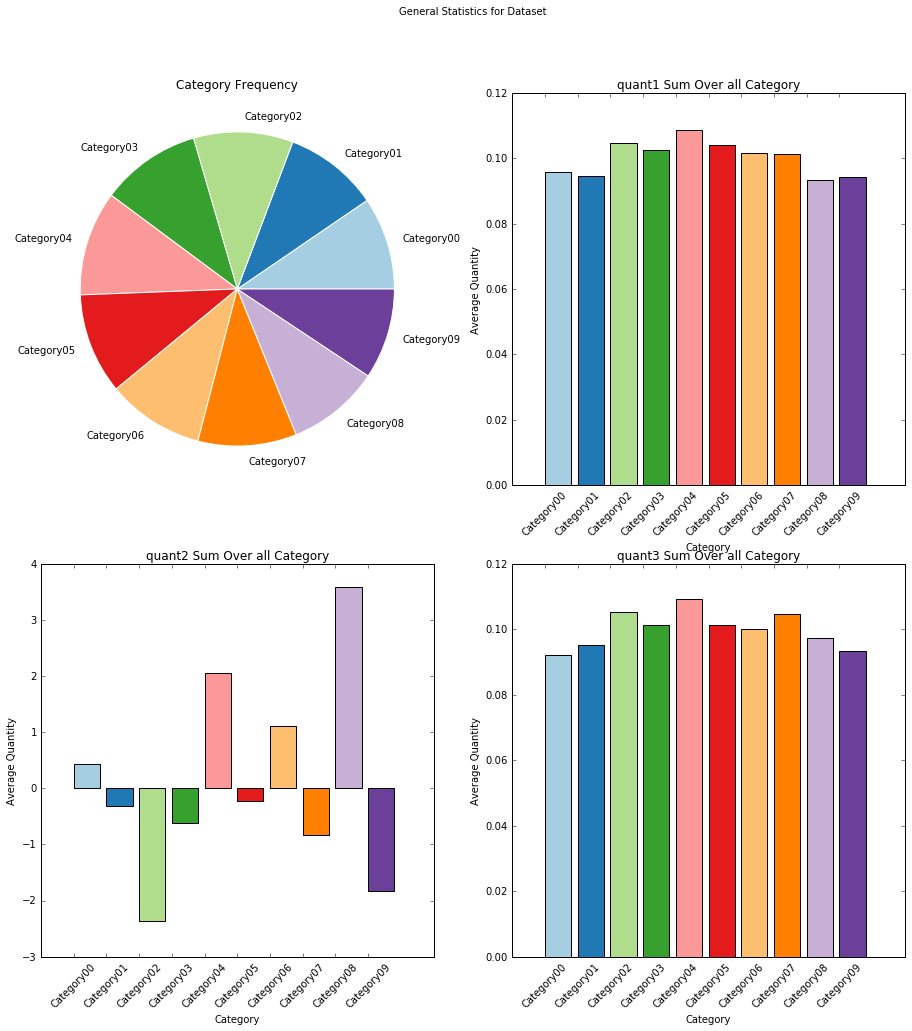

In [3]:
test = AllPurpose(sample,datestr='%d/%m/%y %H:%M')
# General Stat
test.plotGeneralStat()

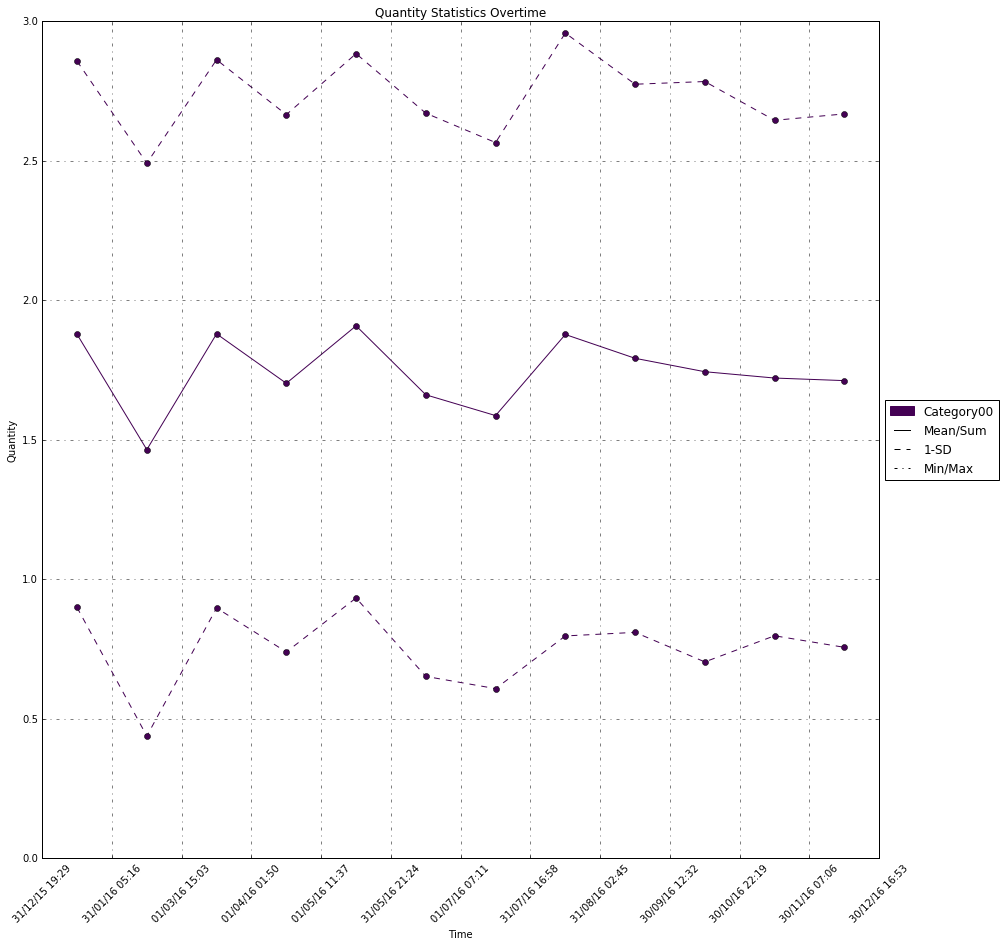

In [4]:
# Detail Stat
test.plotDetailStat()

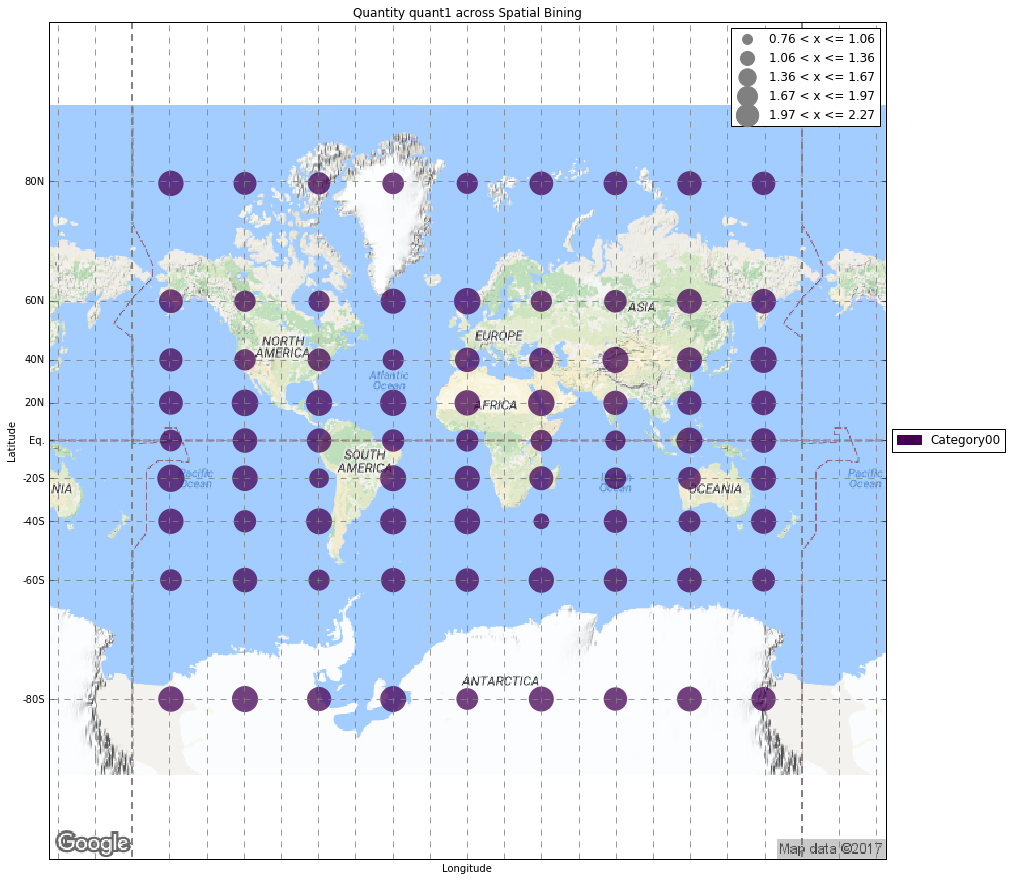

In [5]:
# Plot Spatial Stat
test.plotSpatialStat()

# All Purpose Library

For this task, we build a class library AllPurpose that can be found in AllPurpose.py that can be imported into your visualization. The class needs a Panda Dataframe object as an initialization parameter according to the column naming rules that has given below:
- Name: names
- Date: dates
- Latitude: latitude
- Longitude: longitude
- 1 Categorical label: categorical
- 3 Quantitive columns: quant1, quant2, quant3

The class instantiation can be called using

AllPurpose(data,column_name={},datestr = '%d/%m/%y')
- data: a panda dataframe
- column_name: the column name can be changed as long as you provide correct key for the columns. The default column names are follow
                  {'names': 'names',
                   'dates':'dates',
                   'latitude':'latitude',
                   'longitude':'longitude',
                   'categorical': 'categorical',
                   'quant1': 'quant1',
                   'quant2': 'quant2',
                   'quant3': 'quant3'                  
                  }
- datestr: how you want to display your date string. Some date, by default it will display day/month/year format.

We build three functions that will generate three visualizations described below

----------------------------------------------------------------------------------------------
## AllPurpose.plotGeneralStat()

We firstly visualized the general statistics for the dataset, focusing on the categorical data and three quantitative data. The visualization contains four graphs. Because the graphs are interrelated with each other, we combined them into one static visualization. 

When people are looking at the dataset, they might want to know how many categories are there and how many data falls in each category. So we used a bar chart to show the category frequencies. We can get a general idea about how the categories are distributed from this chart. To improve this graph, we can add the exact number of the frequencies to it.

We then plotted three graphs for the three quant data visualizing how are they distributed among the categories. We chose histogram as our visualization tool in these graphs because we could compare the percentages of quantities in each category intuitively. Since some of the data for quant2 are negative numbers, the quantity sum percentages of the data in this column also appear negative numbers. This may lead to some confusion, so it will be better if we convert all the percentages into positive numbers.

Aesthetic:
- For the Category Frequency Plot, we choose to plot it using Pie chart because this frequency is depicting the percentage of such category over all the data in the dataset.
- For the sum/total quantity for each category, we choose bar plot because it will represent the average value that lies in the particular category. In addition, because the quantity can contain minus value, we can't use the pie chart for this
- For the color, we choose Pastel because its linear color can separate the category the most and it also nice to be seen.

----------------------------------------------------------------------------------------------
## AllPurpose.plotDetailStat()

Our second visualization is an interactive plot, which shows the statistical details of the quantity data, is interactive. We binned the data in order to visualize the trends and changes of the statistics through different times. Users can choose the categories, quantity columns, statistics, and even binning numbers and colors as they want. It makes analyzing and comparing the statistics clear and easy. We haven't found any significant weakness of this visualization, but we are open to suggestions. 

Aesthetic:
- For this detail stat, we decide to build a toolbox that can work for any kind of data as long as the data follow a particular format. This toolbox will produce a visualization of quantity columns and their statistics over time using binning operation.
- We make this toolbox as customizable as possible to support users to get insight about the data. 
- The user can choose which categories they want to visualize by selecting categories in the multi-select box. 
- Quantity columns that one to be displayed can be chosen using the drop down box. 
-  The user also can choose which statistics (mean, min, max,1-SD, or sum) values that they want to display. We choose a straight line (-),  to represent the mean, dashed line (--) to represent 1-SD over the mean, dash-dot line (-.) to represent Min and Max values.
- A number of bins that want to be produced can be chosen using slider box, the default value is 12 bins
- Besides that, the user also can choose the Names that they want to display based on the values in the Names column. By default, All Names will be displayed in this statistics.
- Finally, the user can also choose any supported color that they want to see. By default, the color is Viridis. This will give the user a freedom to choose their own color

----------------------------------------------------------------------------------------------
## AllPurpose.plotSpatialStat()

The last function is also an interactive plot to visualize spatial data. The visualization is plotted on a static google map because it would be too abstract without one. We also made it interactive by adding drop down widgets, so that people can choose to look at specific categories or quantities with different binning scales. A circle represents the binned quantity mean in one spatial area and there are five intervals for the size of circles. People could get intuitive impressions on the spatial distributions of the quantitative data from this visualization. However, since the map is static, we can not see the detailed distribution from a narrower view. We could make the map dynamic so that people can zoom in and out to be able to focus on only one country or an even smaller area. 

Aesthetic:
- This toolbox will provide categories that have maximum average values over spatial space using spatial binning. 
- Firstly, the users can choose which categories they want to display in the visualization. User can choose more than one categories to provide comparison within categories in the spatial space
- Next, users also can choose which quantity column they want to compare
- How much the number of bin that user want to produce is also can be selected using binning slider box
- Finally, users can choose which color they want to represent in their visualization
- Within all the categories displayed in the spatial dimension, this visualization also will give the amount representation using the radius of the circle visualized. Therefore, a legend to provide circle scale is provided on the right top of the visualization.

----------------------------------------------------------------------------------------------
Nikolaus and Yiting worked and finished this part together. Nikolaus was in charge of coding and Yiting was responsible for writeup. We used Salem and Motionless libraries in this part. 

# References

Matplotlib: http://matplotlib.org

Salem: http://salem.readthedocs.io/en/latest/

ipywidgets: http://ipywidgets.readthedocs.io

mplleaflet: https://github.com/jwass/mplleaflet (We don't use this because it is buggy and slow)